In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

In [2]:
tk = 1313
R = 8.3143

gagfcc=-7209.5+118.2007*tk
gagl=3815.93+109.3029*tk-1.044523e-20*tk**7
glag=gagl-gagfcc;
gaufcc=-15745+225.14*tk
gaul=-3352+215.88*tk-3.5899325e-21*tk**7
glau1=gaul-gaufcc
glau=12552-9.385866*tk

In [3]:
def funcs(xl, xs, tk):
    gl = (1-xl)*glag+xl*glau1+R*tk*((1-xl)*torch.log(1-xl)+xl*torch.log(xl))+(1-xl)*xl*(-16402+1.14*tk)
    gs = R*tk*((1-xs)*torch.log(1-xs)+xs*torch.log(xs))+(1-xs)*xs*(-15599)
    glxl = 1367.57-0.3622*tk+0.68552975*10**-20*tk**7+R*tk*(-torch.log(1-xl)+torch.log(xl))-xl*(-16402+1.14*tk)+(1-xl)*(-16402+1.14*tk)
    gsxs = R*tk*(-torch.log(1-xs)+torch.log(xs))+31198*xs-15599
    
    return gl, gs, glxl, gsxs

In [4]:
seq1 = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
    )

seq2 = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
    )

In [39]:
x = torch.arange(1e-6, 100, step=101/100, requires_grad=True)/100

In [6]:
glx, gsx, glxlx, gsxsx = funcs(x, x, tk)

In [ ]:
loss_fn = nn.MSELoss()

opt1 = torch.optim.Adam(seq1.parameters(), lr=0.0001/2)
opt2 = torch.optim.Adam(seq2.parameters(), lr=0.0001/2)
nr_epochs = 15000
inp = torch.tensor([tk/1000], dtype=torch.float)

for i in range(nr_epochs):
    xl, xs = seq1(glx/1000), seq2(gsx/1000)
    #print(xl, xs)

    gl, gs, glxl, gsxs = funcs(xl, xs, tk)
    #print(glxl, gsxs)
    #print(gl - xl * glxl, gs - xs * gsxs)
    
    opt1.zero_grad(), opt2.zero_grad()
    loss = loss_fn(gl - xl * glxl, gs - xs * gsxs) + loss_fn(gsxs, glxl)
    if i % (nr_epochs / 100) == 0:
        print(loss)
    loss.backward()
    opt1.step(), opt2.step()
    #print()

print()
print(xl, xs)
print(glxl, gsxs)
print(gl - xl * glxl, gs - xs * gsxs)

In [72]:
x2 = (x * 1.00) ** 3 #- 12000

In [29]:
xl, xs = seq1(x2), seq2(gsx/1000)

In [30]:
print(xl, xs)

tensor([1.], grad_fn=<SigmoidBackward0>) tensor([0.6026], grad_fn=<SigmoidBackward0>)


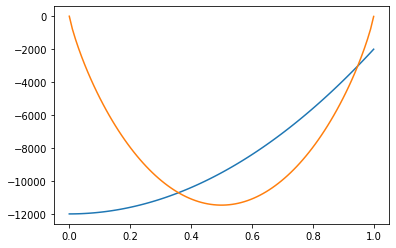

In [26]:
plt.plot(x, x2)
plt.plot(x, gsx)

In [73]:
dx2_dx = grad(outputs=x2, inputs=x, grad_outputs=torch.ones_like(x2))[0]
print(f'dy/da:\n {dx2_dx}')

dy/da:
 tensor([3.0000e-16, 3.0603e-04, 1.2241e-03, 2.7543e-03, 4.8965e-03, 7.6508e-03,
        1.1017e-02, 1.4995e-02, 1.9586e-02, 2.4788e-02, 3.0603e-02, 3.7030e-02,
        4.4068e-02, 5.1719e-02, 5.9982e-02, 6.8857e-02, 7.8344e-02, 8.8443e-02,
        9.9154e-02, 1.1048e-01, 1.2241e-01, 1.3496e-01, 1.4812e-01, 1.6189e-01,
        1.7627e-01, 1.9127e-01, 2.0688e-01, 2.2310e-01, 2.3993e-01, 2.5737e-01,
        2.7543e-01, 2.9409e-01, 3.1337e-01, 3.3327e-01, 3.5377e-01, 3.7489e-01,
        3.9661e-01, 4.1896e-01, 4.4191e-01, 4.6547e-01, 4.8965e-01, 5.1444e-01,
        5.3984e-01, 5.6585e-01, 5.9247e-01, 6.1971e-01, 6.4756e-01, 6.7602e-01,
        7.0509e-01, 7.3478e-01, 7.6507e-01, 7.9598e-01, 8.2751e-01, 8.5964e-01,
        8.9238e-01, 9.2574e-01, 9.5971e-01, 9.9429e-01, 1.0295e+00, 1.0653e+00,
        1.1017e+00, 1.1387e+00, 1.1764e+00, 1.2146e+00, 1.2535e+00, 1.2930e+00,
        1.3331e+00, 1.3738e+00, 1.4151e+00, 1.4570e+00, 1.4995e+00, 1.5427e+00,
        1.5865e+00, 1.6308e+00, 

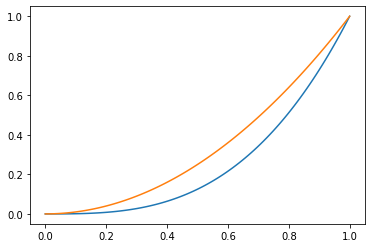

In [75]:
plt.plot(x.detach().numpy(), x2.detach().numpy())
plt.plot(x.detach().numpy(), x.detach().numpy() ** 2)

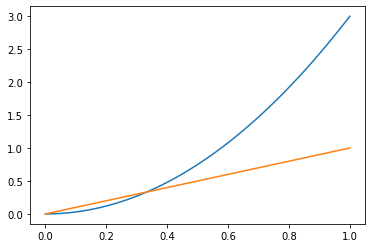

In [77]:
plt.plot(x.detach().numpy(), dx2_dx.detach().numpy())
plt.plot(x.detach().numpy(), x.detach().numpy())